In [1]:
%env CUDA_VISIBLE_DEVICES=2
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from keras.layers import *
from keras.models import Sequential

env: CUDA_VISIBLE_DEVICES=2


Using TensorFlow backend.


In [2]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from IPython.display import HTML

In [3]:
import numpy as np
data = np.load('GAN_sandbox/ecalNT.npz')

In [4]:
data.files

['TotalEnergySci',
 'TotalEnergyAbsorb',
 'ParticlePoint',
 'EnergyDeposit',
 'ParticlePDG',
 'ParticleMomentum']

In [5]:
IMG_SHAPE = data['EnergyDeposit'][9].shape
data_img = data['EnergyDeposit']
print (data_img.shape)

(10000, 30, 30)


In [6]:
data_img.shape 

(10000, 30, 30)

In [7]:
data_img = np.log(data_img + 1)
data_img

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In [8]:
data_img = np.log(data_img + 1)
data_img = np.tanh(data_img)
flat_data = data_img.reshape((900*10000))

## explore data ##

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


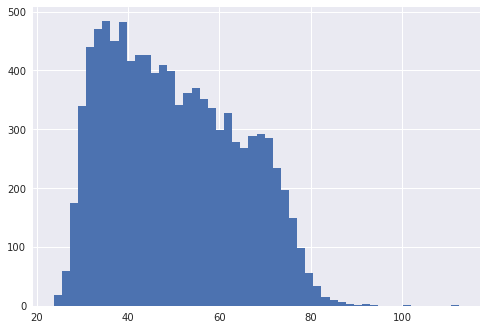

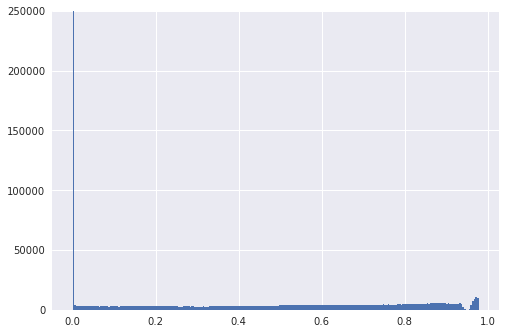

In [9]:
plt.hist(np.sum(data_img, axis=(1,2)), bins = 50)
plt.show()
plt.hist(flat_data, bins = 250)
plt.ylim([0, 250000])
#plt.xlim([-0, 0.1])
plt.show()

REAL


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


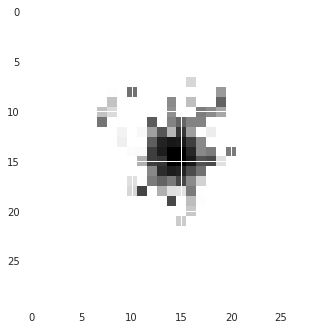

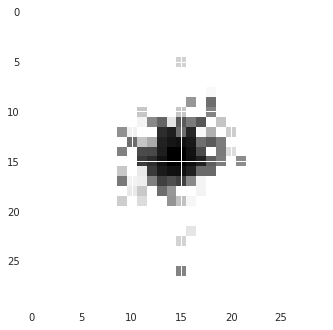

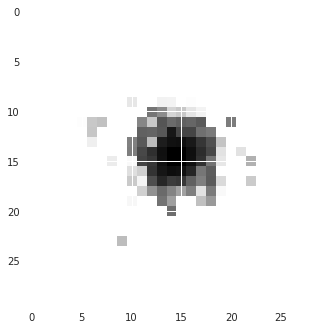

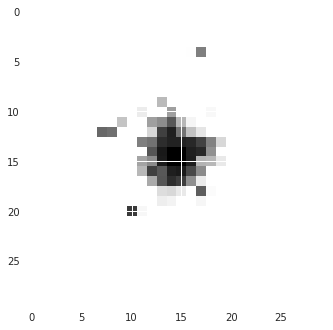

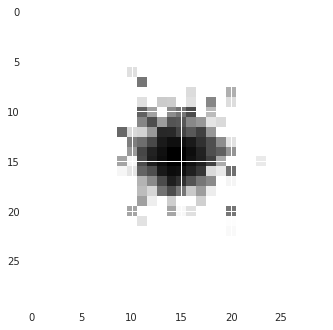

In [10]:
idxs = np.random.choice(np.arange(100), size=5)
print ('REAL')
for ind, elem in enumerate(data_img[idxs]):
    #print (np.log(elem+1))
    plt.imshow(elem)
    plt.show()

In [11]:
np.prod(np.array(IMG_SHAPE))

900

In [12]:
[None,]+list(IMG_SHAPE)

[None, 30, 30]

In [13]:
CODE_SIZE = 32

tf.reset_default_graph()
gen = Sequential()
gen.add(InputLayer([CODE_SIZE]))
gen.add(Dense(16, activation='elu'))
gen.add(Dense(64, activation='elu'))
print (gen.output_shape[1:])
gen.add(Dense(64, activation='elu'))
gen.add(Dense(np.prod(np.array(IMG_SHAPE))))
print (gen.output_shape[1:])
gen.add(Reshape((IMG_SHAPE), input_shape=(np.prod(np.array(IMG_SHAPE)),)))
disc = Sequential()
disc.add(InputLayer(list(IMG_SHAPE)))
disc.add(Flatten())
print (disc.output_shape[1:])
disc.add(Dense(64, activation='elu'))
print (disc.output_shape[1:])
disc.add(Dense(64, activation='elu'))
print (disc.output_shape[1:])
disc.add(Dense(2))
print (disc.output_shape[1:])

batch_size = tf.placeholder_with_default(128, [])

z = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

weight_0 = disc.layers[0].output
weight_1 = disc.layers[1].get_weights()

gen_data = gen(z)
print (real_data.get_shape)
print (gen_data.get_shape)
logits_on_real_data = disc(real_data)
logits_on_gen_data = disc(gen_data)


IS_REAL = 1
IS_FAKE = 0

disc_loss = - 0.5 * tf.reduce_mean( tf.nn.log_softmax(logits_on_real_data)[:, IS_REAL] 
                                   +tf.nn.log_softmax(logits_on_gen_data)[:, IS_FAKE])

gen_loss = - tf.reduce_mean(tf.nn.log_softmax(logits_on_gen_data)[:, IS_REAL])


train_gen = tf.train.GradientDescentOptimizer(1e-3).minimize(gen_loss, var_list = gen.trainable_weights)
train_disc = tf.train.GradientDescentOptimizer(1e-2).minimize(disc_loss, var_list = disc.trainable_weights)

(64,)
(900,)
(900,)
(64,)
(64,)
(2,)
<bound method Tensor.get_shape of <tf.Tensor 'Placeholder_1:0' shape=(?, 30, 30) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'sequential_1/reshape_1/Reshape:0' shape=(?, 30, 30) dtype=float32>>


In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [15]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data_img.shape[0]), size=bsize)
    return data_img[idxs]

In [16]:

feed_dict = {
        real_data:sample_data_batch(100),
        z:sample_noise_batch(100)
    }
#sess.run(train_disc, feed_dict)
#sess.run(train_gen, feed_dict)   

i 99000
4921.73
(2, 2)
4.82991
-2.51111
[[ 0.36314446  1.25540042]
 [ 0.42198616  1.14741588]]


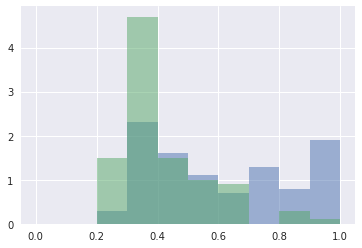

In [17]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

r_ = []
g_ = []
for i in range(100000):
    feed_dict = {
        real_data:sample_data_batch(100),
        z:sample_noise_batch(100)
    }
    for _ in range(5):
        sess.run(train_disc, feed_dict)
    sess.run(train_gen, feed_dict)
    
    if i % 1000 == 0:
        print ('i', i)
        clear_output(True)
        print ('i', i)
        print(np.sum((sess.run(real_data, feed_dict))))
        print (sess.run(logits_on_real_data[:2], feed_dict).shape)
        print (np.max(sess.run(logits_on_real_data, feed_dict)))
        print (np.min(sess.run(logits_on_real_data, feed_dict)))
        print(sess.run(logits_on_real_data, feed_dict)[:2])
        #print(len((sess.run(weight_0, feed_dict))[:2]))
        plt.hist(sess.run(tf.nn.softmax(logits_on_real_data)[:, IS_REAL], feed_dict), range=[0, 1], alpha=0.5, normed=True)
        plt.hist(sess.run(tf.nn.softmax(logits_on_gen_data)[:, IS_REAL], feed_dict), range=[0, 1], alpha=0.5, normed=True)
        plt.show()
        #plt.hist(sess.run(tf.nn.softmax(logits_on_real_data)[:, IS_REAL], feed_dict))
                 #range=[0, 1], alpha=0.5)
        #plt.hist(sess.run(tf.nn.softmax(logits_on_gen_data)[:, IS_REAL], feed_dict))
                # range=[0, 1], alpha=0.5)
        real_ = sess.run(real_data, feed_dict)
        gen_ =  sess.run(gen_data, feed_dict)
        r_.append(real_)
        g_.append(gen_)
        plt.show()

In [20]:
print (np.array(r_).shape, np.array(g_).shape)
nr_ = np.array(r_).reshape(100*100, 30, 30)
ng_ = np.array(g_).reshape(100*100, 30, 30)

(100, 100, 30, 30) (100, 100, 30, 30)


In [ ]:
r_[0]

In [69]:
r_ = []
g_ = []
for i in range(0,20):
    print (i)
    feed_dict = {
            real_data:sample_data_batch(100),
            z:sample_noise_batch(100)
    }
    real_ = sess.run(real_data, feed_dict)
    gen_ =  sess.run(gen_data, feed_dict)
    r_.append(real_data)
    g_.append(z)

0


FailedPreconditionError: Attempting to use uninitialized value dense_1/kernel
	 [[Node: dense_1/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_1/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](dense_1/kernel)]]

Caused by op 'dense_1/kernel/read', defined at:
  File "/opt/conda/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-1edc03d66b13>", line 6, in <module>
    gen.add(Dense(16, activation='elu'))
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/models.py", line 469, in add
    output_tensor = layer(self.outputs[0])
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 825, in build
    constraint=self.kernel_constraint)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 321, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_1/kernel
	 [[Node: dense_1/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_1/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](dense_1/kernel)]]


In [63]:
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'ko-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(x2, y2, 'r.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

(100, 30, 30)

REAL


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


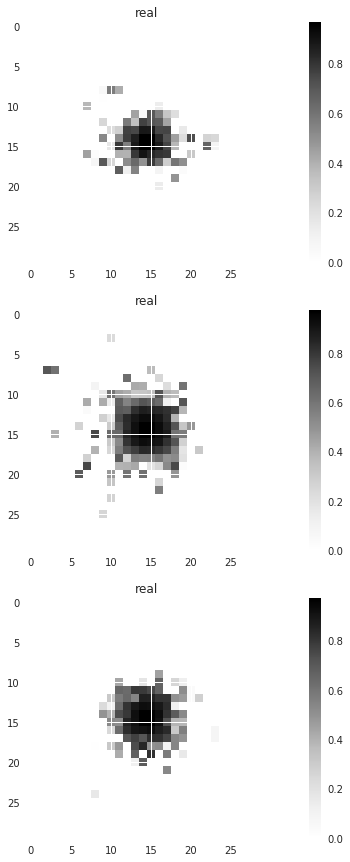

GEN


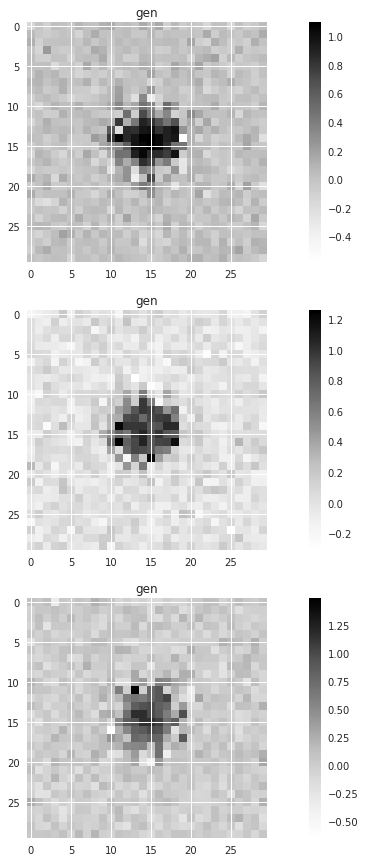

In [47]:
idxs = np.random.choice(np.arange(100), size=3)
print ('REAL')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for ind, elem in enumerate(real_[idxs]):
    plt.subplot(3, 1, ind+1)
    plt.imshow(elem)
    plt.title('real')
    plt.colorbar()
plt.savefig('sq_real.png')
plt.show()
print ('GEN')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for ind, elem in enumerate(gen_[idxs]):
    plt.subplot(3, 1, ind+1)
    plt.imshow(elem)
    plt.title('gen')
    plt.colorbar()
plt.savefig('sq_gen.png')
plt.show()

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


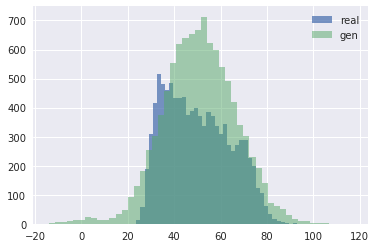

In [46]:
plt.hist(np.sum(nr_, axis=(1,2)), bins=50, alpha = 0.75, label = 'real')
plt.hist(np.sum(ng_, axis=(1,2)), bins=50, alpha = 0.5, label = 'gen')
plt.legend()
plt.savefig('my_gan_energy.png')
plt.show()